# Sensitivity check for choice of impact functions

In this code, we (qualitatively) examine how sensitive modelling outcomes are to the choice of impact functions. For this, we generate 4 scenarios and test these for both hazard types (CF, TC) on 2 countries (PHL, SOM):

* base scenario: 'original' impact functions (about 15), distributed to types of buildings
* min scenario: assigning 4-5 base classes to our building types, taking a high vulnerability scenario for each of them
* med scenario: ditto, taking medium vuln. versions of impfs
* max scenario: ditto, taking low vuln. versions of impfs
* ivm scenario: 'original' ivm impact functions (only 4 classes), as comparison to the CIMA/Capra flood impact functions.

In [33]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard

# select country here
cntry = 'Philippines'

In [34]:
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.1] # filter out rows with basically no population

exp = Exposures(gdf_bem_subcomps.copy())
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf['value'] = 1 # each building type gets value 1

## TC impact functions

### Base scenario

In [3]:
exp.gdf['impf_TC_base'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_TCIMPF_HAZUS)

### Min, med, max scenarios

In [4]:
# we modify the dictionary to point to the "_min", "_med" and "_max" vulnerability functions everywhere 
DICT_TCIMPF_MIN = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'min']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}
DICT_TCIMPF_MED = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'med']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}
DICT_TCIMPF_MAX = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'max']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}

In [5]:
exp.gdf['impf_TC_min'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MIN) 

In [6]:
exp.gdf['impf_TC_med'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MED) 

In [7]:
exp.gdf['impf_TC_max'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MAX) 

### Perform impact calcs and compare

In [8]:
# load TC hazard phl
if cntry == 'Somalia':
    reg = 'IO'
elif cntry == 'Philippines':
    reg = 'WP'
else:
    reg = print('no country-basin assingment found')

haz_TC_dir = Path('/cluster/work/climate/meilers/climada/data/hazard/present')
haz_TC = TropCyclone.from_hdf5(haz_TC_dir.joinpath(f'TC_{reg}_0150as_MIT_H08.hdf5'))

In [9]:
TC = haz_TC.select(extent=(
    exp.gdf['longitude'].min(), exp.gdf['longitude'].max(), exp.gdf['latitude'].min(), exp.gdf['latitude'].max()))

In [10]:
exp.gdf.rename({'impf_TC_base' : 'impf_TC'}, axis=1, inplace=True)

imp_base = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [11]:
exp.gdf.rename({'impf_TC' : 'impf_TC_base'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_min' : 'impf_TC'}, axis=1, inplace=True)

imp_min = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [12]:
exp.gdf.rename({'impf_TC' : 'impf_TC_min'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_med' : 'impf_TC'}, axis=1, inplace=True)

imp_med = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [13]:
exp.gdf.rename({'impf_TC' : 'impf_TC_med'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_max' : 'impf_TC'}, axis=1, inplace=True)

imp_max = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [14]:
print(imp_base.aai_agg, imp_min.aai_agg, imp_med.aai_agg, imp_max.aai_agg)

164.37850605480506 214.77324813035347 17.934575204291917 1.4728661866011676


## FL impact functions

### Base Scenario

In [35]:
exp.gdf['impf_FL_base'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_CIMA)

In [36]:
exp.gdf['impf_FL_ivm'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_IVM)

### Min, med, max scenarios

In [37]:
# manual mapping from vulnerable impf-ids to less vulnerable impf-ids and vice versa (referring do CIMA funcs)
DICT_FLIMPF_MIN = {1:1,2:1,3:1,4:1,5:1,6:6,7:6,8:8,9:8,10:8,11:11,12:12,13:12,14:14,15:15}
DICT_FLIMPF_MED = {1:2, 2:2, 3:2,4:2,5:2,6:7,7:7, 8:7,9:7,10:7,11:11,12:13,13:13,14:15,15:15}
DICT_FLIMPF_MAX = {1:4, 2:4, 3:4, 4:4, 5:5, 6:10, 7:10, 8:10, 9:10, 10:10, 11:11, 12:13,13:13,14:15,15:15}    

In [38]:
exp.gdf['impf_FL_min'] = exp.gdf['impf_FL_base'].map(DICT_FLIMPF_MIN) 

In [39]:
exp.gdf['impf_FL_med'] = exp.gdf['impf_FL_base'].map(DICT_FLIMPF_MED)

In [40]:
exp.gdf['impf_FL_max'] = exp.gdf['impf_FL_base'].map(DICT_FLIMPF_MAX) 

### Perform impact calcs and compare

In [41]:
haz_CF_dir = Path('/cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km')

In [42]:
# get tiles covering the exposure extent
tiles = coastal_flood_hazard.find_tiles(
    exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max())

In [43]:
# load CF hazard phl
CF = coastal_flood_hazard.generate_hazard_object(tiles, haz_CF_dir, 'RCP45', '2020', 'FL')

Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N04E122/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N04E123/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N11E116/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N11E117/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N12E116/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N12E117/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N12E118/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/h

In [44]:
exp.gdf.rename({'impf_FL_base' : 'impf_FL'}, axis=1, inplace=True)

imp_base = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, CF).impact()

2024-05-06 13:24:13,389 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 750 coordinates.


In [46]:
exp.gdf.rename({'impf_FL' : 'impf_FL_base'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_FL_min' : 'impf_FL'}, axis=1, inplace=True)

imp_min = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, CF).impact()

2024-05-06 13:25:44,386 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 750 coordinates.


In [47]:
exp.gdf.rename({'impf_FL' : 'impf_FL_min'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_FL_med' : 'impf_FL'}, axis=1, inplace=True)

imp_med = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, CF).impact()

2024-05-06 13:26:03,117 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 750 coordinates.


In [48]:
exp.gdf.rename({'impf_FL' : 'impf_FL_med'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_FL_max' : 'impf_FL'}, axis=1, inplace=True)

imp_max = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, CF).impact()

2024-05-06 13:26:24,467 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 750 coordinates.


In [49]:
exp.gdf.rename({'impf_FL' : 'impf_FL_max'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_FL_ivm' : 'impf_FL'}, axis=1, inplace=True)

imp_ivm = ImpactCalc(exp, vulnerability.IMPF_SET_FL_IVM, CF).impact()

2024-05-06 13:26:43,985 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 750 coordinates.


In [50]:
print(imp_base.aai_agg, imp_min.aai_agg, imp_med.aai_agg, imp_max.aai_agg, imp_ivm.aai_agg)

13161.625434792628 13161.625434792628 9427.611744061584 8588.458662299845 107824.38346358908


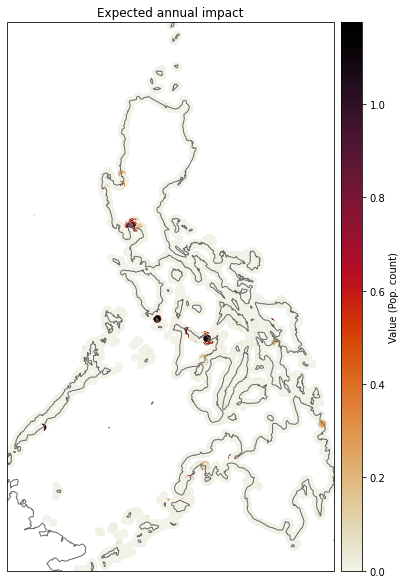

In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

imp_base.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

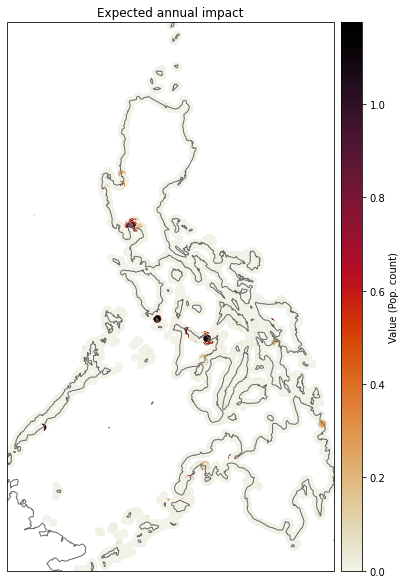

In [59]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

imp_min.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

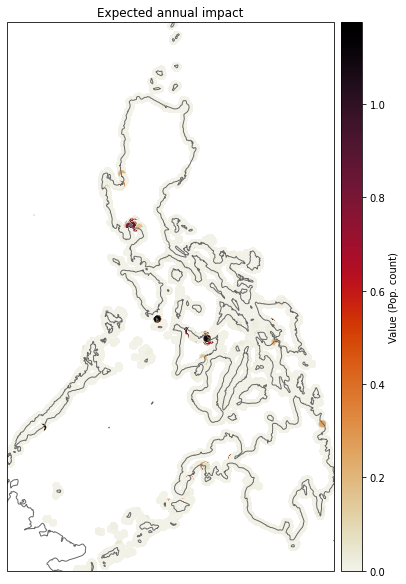

In [60]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

imp_med.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

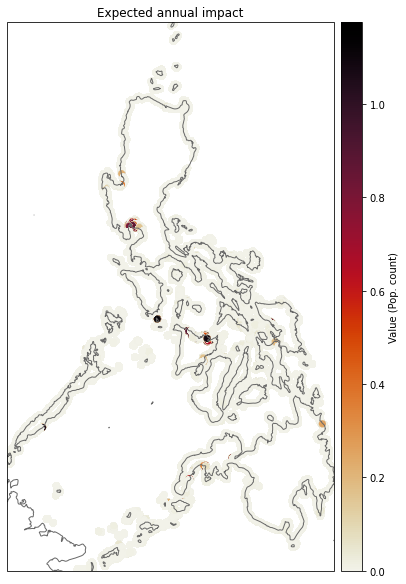

In [61]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

imp_max.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

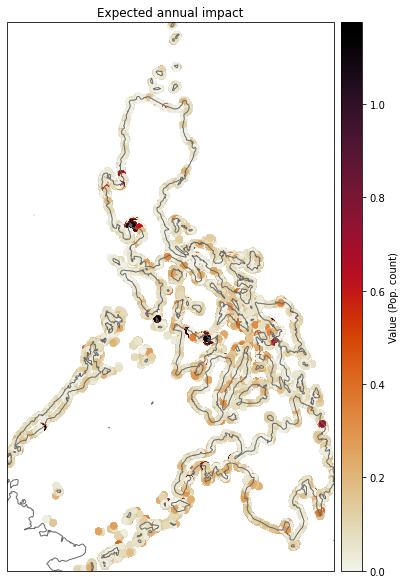

In [62]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

imp_ivm.plot_scatter_eai_exposure(
    ignore_zero=True,
    pop_name=False,
    axis=ax
)

plt.show()

<GeoAxesSubplot:title={'center':'FL max intensity at each point'}>

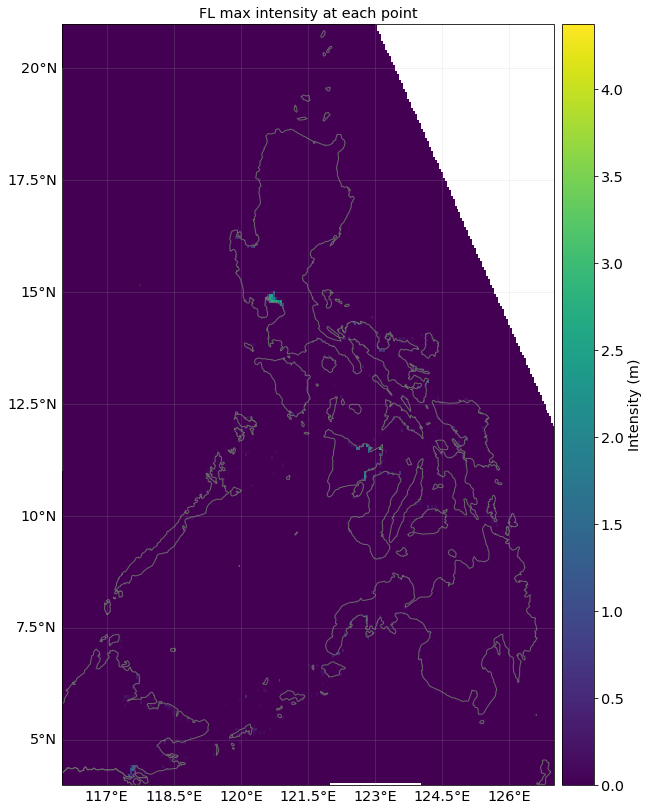

In [63]:
CF.plot_intensity(event=0)